In [26]:
# Imports
import numpy as np
import torch
import matplotlib.pyplot as plt

from cnp.data import EEGGenerator

from cnp.cnp import StandardEEGConvGNP
from cnp.cov import (
    MultiOutputMeanFieldGaussianLayer,
    MultiOutputInnerprodGaussianLayer,
    MultiOutputKvvGaussianLayer
)

from cnp.experiment import WorkingDirectory
from shutil import copyfile
import pickle
import matplotlib

matplotlib.rcParams['text.usetex'] = True

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

def to_numpy(tensor):
    return tensor.detach().cpu().numpy()

In [27]:
# model_dir = '/scratches/cblgpu07/em626/kernelcnp/kernelcnp/experiments/eeg/results/200-16-7-3-50-0/'
# _model_dir = '/scratches/cblgpu07/em626/kernelcnp/kernelcnp/experiments/eeg/results/1000-16-7-3-50-0/'

# copyfile(f'{model_dir}/convGNP/meanfield/hetero/model_best.pth.tar', 'models/convgnp-meanfield')
# copyfile(f'{_model_dir}/convGNP/innerprod/hetero/model_best.pth.tar', 'models/convgnp-innerprod')
# copyfile(f'{model_dir}/convGNP/kvv/hetero/model_best.pth.tar', 'models/convgnp-kvv')

In [28]:
args_num_basis_dim = 512
args_noise_type = 'hetero'
args_jitter = 1e-5
args_num_outputs = 7

device = torch.device('cpu')

# working_directory = WorkingDirectory('/scratches/cblgpu07/em626/kernelcnp/kernelcnp/notebooks/eeg-results/models')
working_directory = WorkingDirectory('/Users/stratis/repos/kernelcnp/kernelcnp/notebooks/eeg-results/models')

Root: /Users/stratis/repos/kernelcnp/kernelcnp/notebooks/eeg-results/models


In [29]:
def load_model(model_name, device, working_directory):
    
    if 'convgnp' in model_name:
        
        output_layer = None

        if 'meanfield' in model_name:
            output_layer = MultiOutputMeanFieldGaussianLayer(num_outputs=args_num_outputs)

        elif 'innerprod' in model_name:
            output_layer = MultiOutputInnerprodGaussianLayer(num_outputs=args_num_outputs,
                                                             num_embedding=args_num_basis_dim,
                                                             noise_type=args_noise_type,
                                                             jitter=args_jitter)

        elif 'kvv' in model_name:
            output_layer = MultiOutputKvvGaussianLayer(num_outputs=args_num_outputs,
                                                       num_embedding=args_num_basis_dim,
                                                       noise_type=args_noise_type,
                                                       jitter=args_jitter)

        model = StandardEEGConvGNP(num_channels=args_num_outputs,
                                   output_layer=output_layer)
        
    elif 'convnp' in model_name:
        model = StandardPredPreyConvNP(input_dim=1, num_samples=16)

    # Load model to appropriate device
    model = model.to(device)

    # Load model from saved state
    load_dict = torch.load(working_directory.file(f'{model_name}', exists=True), map_location=torch.device('cpu'))
    model.load_state_dict(load_dict['state_dict'])
    
    return model

In [30]:
# # Load data
# train_data = EEGGenerator(split='train',
#                           num_total_channels=7,
#                           num_target_channels=3,
#                           batch_size=1,
#                           batches_per_epoch=128,
#                           target_length=50)
# _data = list(train_data)

In [31]:
with open('eeg-data.pkl', 'rb') as file:
    data = pickle.load(file)
file.close()

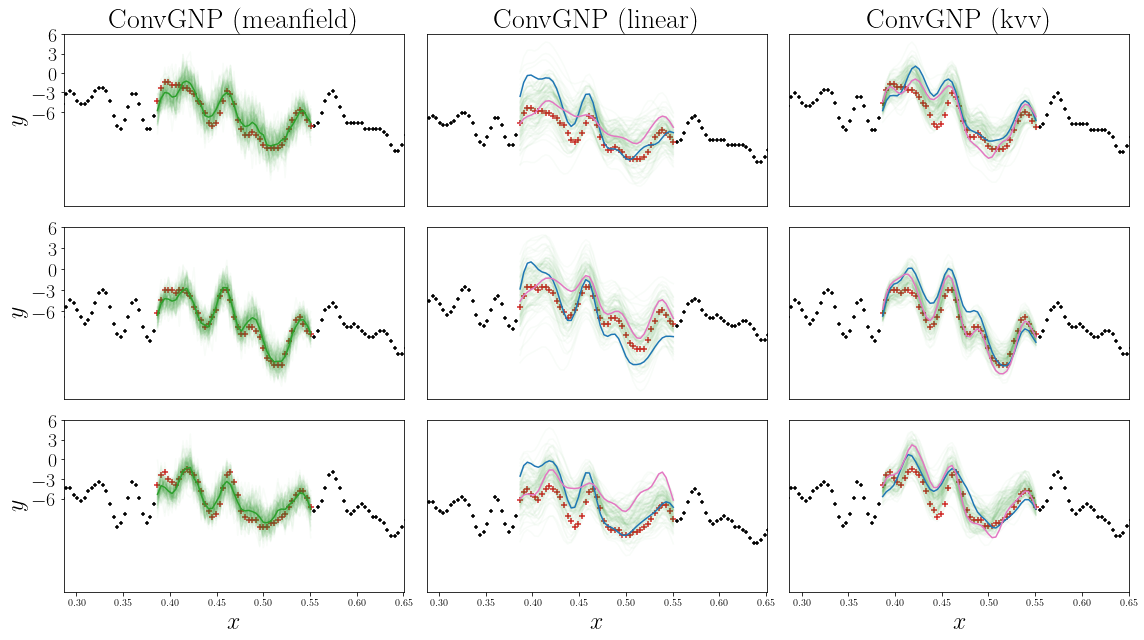

In [32]:
model_infos = [
    ('ConvGNP (meanfield)', StandardEEGConvGNP, MultiOutputMeanFieldGaussianLayer, 'convgnp-meanfield'),
    ('ConvGNP (linear)', StandardEEGConvGNP, MultiOutputInnerprodGaussianLayer, 'convgnp-innerprod'),
    ('ConvGNP (kvv)', StandardEEGConvGNP, MultiOutputKvvGaussianLayer, 'convgnp-kvv')
]

plt.figure(figsize=(16, 9))
    
for j, model_info in enumerate(model_infos):
    
    model = load_model(model_name=model_info[-1],
                       device=device,
                       working_directory=working_directory)
    
    mask_idx = torch.where(torch.any(data['m_target'][0, :, :] == 1, dim=-1))[0]
    m_target = torch.zeros_like(data['m_context'])
    m_target[:, mask_idx, :] = 0
    m_target = m_target[:, :, -10:-10]
    x_target = data['x_context'][:, -10:-10, :].to(device)
    
    samples, samples_masked = model.sample(x_context=data['x_context'].to(device),
                                           y_context=data['y_context'].to(device),
                                           m_context=data['m_context'].to(device),
                                           x_target=data['x_target'].to(device),
                                           m_target=data['m_target'].to(device),
                                           num_samples=100,
                                           noiseless=True,
                                           double=True)
    
    samples = to_numpy(samples)
    samples_masked = to_numpy(samples_masked)
    
    _samples, _samples_masked = model.sample(x_context=data['x_context'].to(device),
                                             y_context=data['y_context'].to(device),
                                             m_context=data['m_context'].to(device),
                                             x_target=data['x_target'].to(device),
                                             m_target=data['m_target'].to(device),
                                             num_samples=3,
                                             noiseless=True,
                                             double=True)
    
    _samples = to_numpy(_samples)
    _samples_masked = to_numpy(_samples_masked)
    
    x_ctx = to_numpy(data['x_context'])
    y_ctx = to_numpy(data['y_context'])
    x_trg = to_numpy(data['x_target'])
    y_trg = to_numpy(data['y_target'])
    
    x_target = to_numpy(x_target)
    
    k = 0
    
    for i in range(7):
        
        if torch.any(data['m_target'][0, i, :] == 1, dim=0):
            
            mask = torch.clone(data['m_context'])
            mask[torch.where(mask == 0.)] = float('nan')
    
            plt.subplot(3, 3, 3*k+1+j)
    
            plt.scatter(x_ctx[0, :, 0], y_ctx[0, i, :]*mask[0, i, :].numpy(), marker='+', color='k', s=10)
            plt.plot(x_trg[0, :, 0], samples[:, 0, i, :].T, color='tab:green', alpha=0.03)
#             plt.plot(x_target[0, :, 0], samples[:, 0, i, :].T, color='tab:green', alpha=0.03)
#             plt.plot(x_target[0, :, 0], samples[::10, 0, i, :].T)
            
            if 'meanfield' in model_info[0]:
                plt.plot(x_trg[0, :, 0], np.mean(samples[:, 0, i, :], axis=0), color='tab:green', alpha=1.)
#                 plt.plot(x_target[0, :, 0], np.mean(samples[:, 0, i, :], axis=0), color='tab:green', alpha=1.)
                
            else:
                plt.plot(x_trg[0, :, 0], _samples[0, 0, i, :].T, color='tab:blue', alpha=1.)
                plt.plot(x_trg[0, :, 0], _samples[1, 0, i, :].T, color='tab:pink', alpha=1.)
#                 plt.plot(x_target[0, :, 0], _samples[0, 0, i, :].T, color='tab:blue', alpha=1.)
#                 plt.plot(x_target[0, :, 0], _samples[1, 0, i, :].T, color='tab:pink', alpha=1.)
                
#             plt.plot(x_trg[0, :, 0], _samples[0, 0, i, :].T, alpha=1., color='tab:green')
#             plt.plot(x_trg[0, :, 0], _samples[1, 0, i, :].T, alpha=1., color='tab:green')
#             plt.plot(x_trg[0, :, 0], _samples[2, 0, i, :].T, alpha=1., color='tab:blue')
#             plt.plot(x_trg[0, :, 0], np.mean(samples[:, 0, i, :].T, axis=-1), color='tab:green', alpha=1)
            plt.scatter(x_trg[0, :, 0], y_trg[0, i, :], color='tab:red', marker='+')
            
            plt.xlim([x_trg[0, :, 0].min()-0.1, x_trg[0, :, 0].max()+0.1])
            
#             plt.xlim([0.75, 1.0])
#             plt.xticks(np.linspace(0.5, 1.0, 6), fontsize=20)
    
            if k == 0:
#                 plt.ylim([-6.5, 6.5])
                plt.xticks([])
                plt.yticks(np.linspace(-6., 6., 5), fontsize=20)
                plt.title(model_info[0], fontsize=28)
                
            if k == 1:
#                 plt.ylim([-8.5, 6.5])
                plt.xticks([])
                plt.yticks(np.linspace(-6., 6., 5), fontsize=20)
                
            if k == 2:
#                 plt.ylim([-6.5, 6.5])
                plt.xlabel('$x$', fontsize=24)
                plt.yticks(np.linspace(-6., 6., 5), fontsize=20)
                
            if j == 0:
                plt.ylabel('$y$', fontsize=24)
                
            else:
                plt.yticks([])
            
            k = k + 1
            
        else:
            continue
            
plt.tight_layout()
plt.savefig('eeg-plots.pdf')
plt.show()

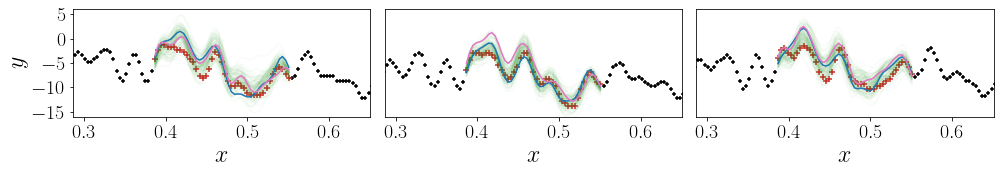

In [39]:
with open('eeg-data.pkl', 'rb') as file:
    data = pickle.load(file)
file.close()

plt.figure(figsize=(14, 2.5))

np.random.seed(0)
torch.manual_seed(0)
    
model_info = model_infos[2]
    
model = load_model(model_name=model_info[-1],
                   device=device,
                   working_directory=working_directory)

mask_idx = torch.where(torch.any(data['m_target'][0, :, :] == 1, dim=-1))[0]
m_target = torch.zeros_like(data['m_context'])
m_target[:, mask_idx, :] = 0
m_target = m_target[:, :, -10:-10]
x_target = data['x_context'][:, -10:-10, :].to(device)

samples, samples_masked = model.sample(x_context=data['x_context'].to(device),
                                       y_context=data['y_context'].to(device),
                                       m_context=data['m_context'].to(device),
                                       x_target=data['x_target'].to(device),
                                       m_target=data['m_target'].to(device),
                                       num_samples=100,
                                       noiseless=True,
                                       double=True)

samples = to_numpy(samples)
samples_masked = to_numpy(samples_masked)

_samples, _samples_masked = model.sample(x_context=data['x_context'].to(device),
                                         y_context=data['y_context'].to(device),
                                         m_context=data['m_context'].to(device),
                                         x_target=data['x_target'].to(device),
                                         m_target=data['m_target'].to(device),
                                         num_samples=3,
                                         noiseless=True,
                                         double=True)

_samples = to_numpy(_samples)
_samples_masked = to_numpy(_samples_masked)

x_ctx = to_numpy(data['x_context'])
y_ctx = to_numpy(data['y_context'])
x_trg = to_numpy(data['x_target'])
y_trg = to_numpy(data['y_target'])

x_target = to_numpy(x_target)

k = 0

for i in range(7):

    if torch.any(data['m_target'][0, i, :] == 1, dim=0):

        mask = torch.clone(data['m_context'])
        mask[torch.where(mask == 0.)] = float('nan')

        plt.subplot(1, 3, k+1)

        plt.scatter(x_ctx[0, :, 0], y_ctx[0, i, :]*mask[0, i, :].numpy(), marker='+', color='k', s=10)
        plt.plot(x_trg[0, :, 0], samples[:, 0, i, :].T, color='tab:green', alpha=0.03)
#             plt.plot(x_target[0, :, 0], samples[:, 0, i, :].T, color='tab:green', alpha=0.03)
#             plt.plot(x_target[0, :, 0], samples[::10, 0, i, :].T)

        if 'meanfield' in model_info[0]:
            plt.plot(x_trg[0, :, 0], np.mean(samples[:, 0, i, :], axis=0), color='tab:green', alpha=1.)
#                 plt.plot(x_target[0, :, 0], np.mean(samples[:, 0, i, :], axis=0), color='tab:green', alpha=1.)

        else:
            plt.plot(x_trg[0, :, 0], _samples[0, 0, i, :].T, color='tab:blue', alpha=1.)
            plt.plot(x_trg[0, :, 0], _samples[1, 0, i, :].T, color='tab:pink', alpha=1.)
            
        plt.scatter(x_trg[0, :, 0], y_trg[0, i, :], color='tab:red', marker='+')


#             plt.xlim([0.75, 1.0])
#             plt.xticks(np.linspace(0.5, 1.0, 6), fontsize=20)

        if k == 0:
            plt.yticks(np.linspace(-15., 5., 5), fontsize=20)
            plt.ylabel('$y$', fontsize=24)
        
        else:
            plt.yticks([])
            
        plt.xlim([x_trg[0, :, 0].min()-0.1, x_trg[0, :, 0].max()+0.1])
        plt.ylim([-16, 6])
        plt.xticks(np.linspace(0.3, 0.6, 4), fontsize=20)
        plt.xlabel('$x$', fontsize=24)

        k = k + 1

    else:
        continue

plt.tight_layout()
plt.savefig('eeg-plots-rescaled.pdf')
plt.show()